# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
%pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163706 sha256=16f129bb1576cba03e404b4619352e03a044f20b89a82ef740cd103db3f99caf
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# Model Selection and Evaluation Libraries
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.metrics import mean_squared_error, mean_absolute_error  # To evaluate model performance

# Surprise-specific Libraries and Tools
from surprise import Reader, Dataset  # To load dataset for Surprise-based models
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans  # For user-user/item-item similarity-based models
from surprise import accuracy
from surprise.model_selection import KFold # For implementing cross validation

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
path = "/content/drive/MyDrive/DSML MIT Course/Recommendation Systems/Final Project/ratings_Electronics.csv"

df = pd.read_csv(path, names=['user_id', 'prod_id', 'rating', 'timestamp'])
df.drop('timestamp', axis=1, inplace=True)   # I'm not using 'timestamp' for this analysis


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Filter out products with fewer than 5 ratings
prod_counts = df['prod_id'].value_counts()
remove_prods = prod_counts[prod_counts < 5].index
df_intermediate = df.loc[~df.prod_id.isin(remove_prods)]

# Now filter out users with fewer than 50 ratings using the intermediate DataFrame
user_counts = df_intermediate['user_id'].value_counts()
remove_users = user_counts[user_counts < 50].index
df_final = df_intermediate.loc[~df_intermediate.user_id.isin(remove_users)]

# Check the final counts for users and products
user_counts_final = df_final['user_id'].value_counts()
prod_counts_final = df_final['prod_id'].value_counts()

print("\nIntermediate User Counts:\n", df_intermediate['user_id'].value_counts().tail() )
print("\nIntermediate Product Counts:\n", df_intermediate['prod_id'].value_counts().tail() )
print("Final User Counts:\n", user_counts_final.tail())
print("\nFinal Product Counts:\n", prod_counts_final.tail())

print("-"*50)
df_final.shape    # To check the size of the new filtered dataset


Intermediate User Counts:
 A2XFI01DNC33C5    1
A1GG9X0W83QWY     1
A9LGU3LAQL9IV     1
APF2J4Q01DW1R     1
A10M2KEFPEQDHN    1
Name: user_id, dtype: int64

Intermediate Product Counts:
 B003NJUPQE    5
B004UTRP9Q    5
B004UTSCZW    5
B0007MAJBG    5
B001UBOJ8M    5
Name: prod_id, dtype: int64
Final User Counts:
 A1ZPUEHF4AES86    50
AR1T36GLLAFFX     50
AW6FQE5QRF2LM     50
A1FOSIV4TWZFR7    50
AN0JK8OQLUC55     50
Name: user_id, dtype: int64

Final Product Counts:
 B0029ILMTE    1
B0029HPSNG    1
B0029F21JW    1
B0029EBLMG    1
B0038X9VPG    1
Name: prod_id, dtype: int64
--------------------------------------------------


(107263, 3)

Each time we remove products below the 5 review threshold, we end up with additional users who fall below the 50 review threshold.  Conversely, each time we remove users who are below the 50 review threshold, we reduce the number of products that meet the 5 review threshold.  Therefore, we (probably) cannot totally remove both thresholds unless the dataset aligns well, and I will prioritize getting users with 50 reviews.   This filter has reduced the dataset size to 107,263, which is a bit less than 1.4% of the original.  This might be too aggressive a cut, but I will examine this final dataset to see what insights may be gleaned.

In [ ]:
# Cleaning up my largest unused variable to free up space

import gc
del df_intermediate
gc.collect()

0

## **Exploratory Data Analysis**

### **Review the look and shape of the dataset**

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
631,A3TAS1AG6FMBQW,0972683275,5.0


In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(107263, 3)

As noted previously, we have 107,263 entries in three columns, with user_id, prod_id, and rating.

### **Data types**

In [ ]:
# Check data types
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [ ]:
# Confirming the range that the 'rating' variable can take

df_final["rating"].value_counts()

5.0    59943
4.0    28236
3.0    10430
2.0     4534
1.0     4120
Name: rating, dtype: int64

**Observations**

The 'user_id' and 'prod_id' are objects and 'rating' is a float.  This is fine and I don't necessarily need to change any of those.  'prod_id' has alphanumeric characters and leading 0s, so I will keep it as is. Though it won't make a big difference, all of my ratings are integers so I will convert the datatype to integer.  Because some of the checks I do below are based on particular user_ids, I will not use a Label Encoder on them.  They are short enough that I don't expect it to increase my processing time too greatly.

In [ ]:
# Convert 'rating' from float to integer
df_final['rating'] = df_final['rating'].astype(int)


### **Checking for missing values, duplicate values, and unique observations**

In [ ]:
# Check for missing values present and provide observations
df_final.info()

# Check for duplicate values
num_duplicates = df_final.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

# Check for unique values in user_id and prod_id
print("\nFinal Dataset")
print(f"\nNumber of unique users: {df_final['user_id'].nunique()}")
print(f"\nNumber of unique products: {df_final['prod_id'].nunique()}")

# Check for unique values in user_id and prod_id in the original, unfiltered dataset for comparison
print("\nOriginal Dataset")
print(f"\nNumber of unique users in unfiltered dataset: {df['user_id'].nunique()}")
print(f"\nNumber of unique products in unfiltered dataset: {df['prod_id'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107263 entries, 118 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  107263 non-null  object
 1   prod_id  107263 non-null  object
 2   rating   107263 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.3+ MB

Number of duplicate rows: 0

Final Dataset

Number of unique users: 1320

Number of unique products: 36915

Original Dataset

Number of unique users in unfiltered dataset: 4201696

Number of unique products in unfiltered dataset: 476002


**Observations**

- There are no nulls and no duplicates, which is great.
- The data is extremely sparse, even having filtered the original dataset for users and products with a large amount of interactions.  With 36,915 products and 1,320 users, the potential user-item matrix would have about 48.7 million possible interactions, of which only 107,263 are known (a sparsity of about 99.78%).
- I am again concerned about having a relatively small and still sparse dataset, particularly when it comes to building a collaborative filtering model. I'm especially uncomfortable with only 1320 unique users.
-**Note**: *I attempted to perform later steps with this larger dataset size only filtering out users with fewer than 30 interactions instead of 50, but that ended up being too computationally expensive and I am sticking with the smaller df_final.*

In [ ]:
# I'm removing this larger df_new dataset because it turns out to be too computationally expensive for me to run with the later models


'''
# Filter out products with fewer than 5 ratings
prod_counts = df['prod_id'].value_counts()
remove_prods = prod_counts[prod_counts < 5].index
df_intermediate = df.loc[~df.prod_id.isin(remove_prods)]

# Now filter out users with fewer than 30 ratings using the intermediate DataFrame
user_counts = df_intermediate['user_id'].value_counts()
remove_users = user_counts[user_counts < 30].index
df_new = df_intermediate.loc[~df_intermediate.user_id.isin(remove_users)]

# Check the final counts for users and products
user_counts_new = df_new['user_id'].value_counts()
prod_counts_new = df_new['prod_id'].value_counts()

print("New User Counts:\n", user_counts_new.tail())
print("\nNew Product Counts:\n", prod_counts_new.tail())

print("-"*50)
df_new.shape    # To check the size of the new filtered dataset

# Check for unique values in user_id and prod_id
print("New Dataset")
print(f"\nNumber of unique users in new dataset: {df_new['user_id'].nunique()}")
print(f"\nNumber of unique products in new dataset: {df_new['prod_id'].nunique()}")
'''

New User Counts:
 A1A2F1ZOWOPNJB    30
A2KZQEKUS3G02I    30
A1Q33MTP73V4QJ    30
A18KLWANZOBG0J    30
A2XXCCT0TBVDIE    30
Name: user_id, dtype: int64

New Product Counts:
 B00451A15Y    1
B00450K36W    1
B00450AD7Q    1
B0044ZVH9A    1
0594451647    1
Name: prod_id, dtype: int64
--------------------------------------------------
New Dataset

Number of unique users in new dataset: 4409

Number of unique products in new dataset: 58550


This new dataset has some 4400 unique users instead of only 1300 some.  Though the dataset is even sparser, I feel better with having 3 x more users.

There are also now 58,550 unique products instead of almost 37,000.

In [ ]:
'''
# Making the same changes to the datatypes as I did for df_final

# Convert 'rating' from float to integer
df_new['rating'] = df_new['rating'].astype(int)
'''

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable on original dataset for comparison
print("ORIGINAL DATASET")
df.describe().T


ORIGINAL DATASET


,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [ ]:
# Summary statistics of 'rating' variable on filtered dataset
print("NEW DATASET")
df_final['rating'].describe().to_frame().T

NEW DATASET


,count,mean,std,min,25%,50%,75%,max
rating,107263.0,4.261833,1.049907,1.0,4.0,5.0,5.0,5.0


**Observations**

The final dataset is skewed to the left, with a mean of 4.26, the median rating already being the highest of '5, and even the first quartile is a '4'.  This is even more skewed than the original unfiltered dataset, having a slightly higher mean, with a tighter standard deviation.

### **Checking the rating distribution**

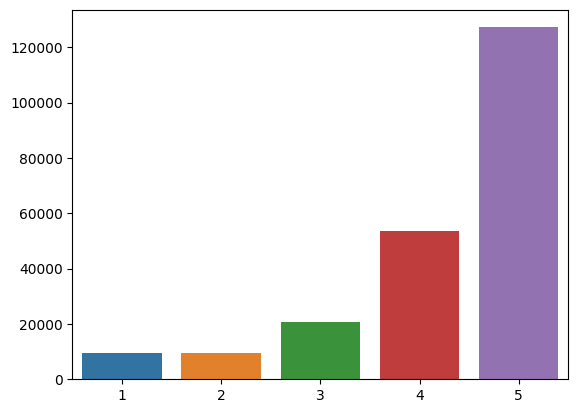

5    0.576578
4    0.242447
3    0.093878
2    0.043687
1    0.043410
Name: rating, dtype: float64

In [ ]:
# Bar plot of ratings
sns.barplot(x=df_final['rating'].value_counts().index, y=df_final['rating'].value_counts().values)
plt.show()

perc = df_final['rating'].value_counts(normalize=True)
perc

**Observations**

This provides visible corroboration of the left-skewedness of the dataset.  A significant majority of the ratings are '5', with relatively very few '1's, '2's, and '3's.  ~57% of the ratings are '5', ~24% are '4's, and '1's, '2's, and '3's altogether comprise only ~18% of the ratings.  This may be because of a general tendency to be more generous with ratings or because the filtered dataset is composed of the products with the most interactions, which may also be the most popular and therefore tend to be higher-rated.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
user_ratings = df_final.value_counts(["user_id"])

print("Top 10 users based on the number of ratings")
user_ratings.head(10)

Top 10 users based on the number of ratings


user_id       
ADLVFFE4VBT8      468
A5JLAU2ARJ0BO     463
A3OXHLG6DIBRW8    456
A6FIAB28IS79      412
A680RUE1FDO8B     381
A1ODOGXEYECQQ8    360
A36K2N527TXXJN    296
AWPODHOB4GFWL     293
ARBKYIVNYWK3C     285
A25C2M3QF9G7OQ    280
dtype: int64

**Observations**

The top user based on number of ratings has 468 ratings, and the top 4 have over 400 each.  By number 10, the number of ratings has fallen to 280.  The top users definitely each have a significant number of product reviews.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_ratings = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
ratings_count = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
ratings_df = pd.concat([average_ratings, ratings_count], axis=1)
ratings_df.columns = ['average_rating', 'rating_count']

# Sort the dataframe by average of ratings in the descending order
ratings_df.sort_values(by='average_rating', ascending=False, inplace=True)

# See the first five records of the "final_rating" dataset
ratings_df.head()

,average_rating,rating_count
prod_id,,
0594451647,5.0,1
B003T6M6H2,5.0,1
B003SEE90M,5.0,1
B003SE6I7O,5.0,1
B003SE6I0Q,5.0,1


In [ ]:
# Define the function to get top n products
def top_n_prods(data, n, min_interaction=50):
    # Finding products with a minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='average_rating', ascending=False)

    # Return the top n product indices
    return recommendations.head(n).index

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Get the top 5 product IDs
top_product_ids = top_n_prods(ratings_df, 5, 50)

# Select the corresponding rows from ratings_df
top_products_df = ratings_df.loc[top_product_ids]

# Display the DataFrame with 'prod_id', 'rating_count', and 'average_rating'
top_products_df

,average_rating,rating_count
prod_id,,
B0052SCU8U,4.942623,122
B003FVJYF8,4.912281,57
B004LSNF04,4.890909,55
B001TH7GUU,4.872832,173
B00316263Y,4.868132,91


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
# Get the top 5 product IDs with 100 minimum interactions
top_product_ids = top_n_prods(ratings_df, 5, 100)

# Select the corresponding rows from ratings_df
top_products_df = ratings_df.loc[top_product_ids]

# Display the DataFrame with 'prod_id', 'rating_count', and 'average_rating'
top_products_df

,average_rating,rating_count
prod_id,,
B0052SCU8U,4.942623,122
B001TH7GUU,4.872832,173
B003ES5ZUU,4.865229,371
B001TH7GSW,4.833333,126
B00E3W15P0,4.817391,115


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Import the necessary classes
from surprise import Dataset, Reader

# Create a Reader object
reader = Reader(rating_scale=(1, 5))

# Load the DataFrame into DatasetAutoFolds
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Perform the train/test split (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.20)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # similarity measure
    'user_based': True  # compute similarities between users
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo = KNNBasic(sim_options=sim_options, verbose=False, random_state = 1)

# Fit the model on the training data
model2 = algo.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model2, k = 10, threshold = 3.5)

RMSE: 1.1355
Precision:  0.838
Recall:  0.753
F_1 score:  0.793


**Observations**

The F_1 score for this model of 0.793 seems pretty decent for a first pass.  The RMSE of ~1.14 does seem pretty high for a 5 point rating scale where the vast majority of the observations are rating 4 or 5.  

The Recall indicates that of all the relevant products, 75% are recommended.  The Precision indicates that out of all the recommended products, 84% are relevant.  

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:

# Predicting rating for a sample user with an interacted product
predicted_rating = model2.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


**Observations**

The result was that the model predicted a rating of 3.33 when the actual was 5.  This is quite far off, especially when the majority of the reviews are '4's and '5's.

Not a great result.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"

# Filter the DataFrame to find users where prod_id is not "1400501466"
users_not_rated_specific_product = df_new[df_new['prod_id'] != '1400501466']['user_id'].unique()

# Select the first user from the filtered list
unique_user_id = users_not_rated_specific_product[0] if len(users_not_rated_specific_product) > 0 else None

# unique_user_id will be one user_id that meets the criteria or None if no such user exists
unique_user_id

'A3BY5KCNQZXV5U'

* It can be observed from the above list that **user "A3BY5KCNQZXV5U" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A3BY5KCNQZXV5U` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
predicted_rating = model2.predict(uid="A3BY5KCNQZXV5U", iid='1400501466', verbose=True)

user: A3BY5KCNQZXV5U item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 2, 'was_impossible': False}


**Observations**

The model predicted that user A3BY5KCNQZXV5U would rate product 1400501466 as a '3'.  The model is successfully able to make predictions, but a result of '3', while certainly possible, seems relatively unlikely given the rating distribution skewing heavily to '4's and '5's.  

I'm going to do some hyperparameter tuning to determine if this model can be improved.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [5, 20, 40], 'min_k': [2, 5, 8],
              'sim_options': {'name': ['msd', 'cosine', 'Pearson'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



1.0711328986251234
{'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:

# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
model2_opt = KNNBasic(sim_options=sim_options, k=40, min_k=5, verbose=False, random_state = 1)

# Training the algorithm on the train set
model2_opt.fit(trainset)

# Let us compute precision@k and recall@k
precision_recall_at_k(model2_opt)


RMSE: 1.0662
Precision:  0.829
Recall:  0.763
F_1 score:  0.795


**Observations**

The original non-optimized values were:
RMSE: 1.1355
Precision:  0.838
Recall:  0.753
F_1 score:  0.793

The new accuracy metrics on the optimized model are:
RMSE: 1.0662
Precision:  0.829
Recall:  0.763
F_1 score:  0.795

The precision, recall, and F_1 score of the optimized model are extremely close to the unoptimized version, and the RMSE showed a modest improvement of ~0.07.  Let's have it perform some example predictions.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use model2_opt model to recommend for a known user-item interaction: userId "A3LDPF5FMB782Z" and productId 1400501466
predicted_rating = model2_opt.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


In [ ]:
# Use model2_opt model to recommend for unknown user-item interaction: userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = model2_opt.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


**Observations**

This optimized model produced the same prediction for the known user-item interaction as the unoptimized model, and for the unknown user-item interaction it failed to generate predictions due to not finding enough neighbors.  This model is not performing well on this dataset with the tests I have attempted so far. I'm going to do a quick build and test of the model based on the dataset df_final (with around 1300 unique users) instead of using df_new (with around 4400 unique users).  This is a smaller dataset but with a higher interaction threshold for the users, so hopefully the data is of better quality.

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data2 = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.20)

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',  # similarity measure
    'user_based': True  # compute similarities between users
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo = KNNBasic(sim_options=sim_options, verbose=False, random_state = 1)

# Fit the model on the training data
model2_2 = algo.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(model2_2, k = 10, threshold = 3.5)

RMSE: 1.1474
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


In [ ]:
# Use model2_2 to recommend for a known user-item interaction: userId "A3LDPF5FMB782Z" and productId 1400501466
predicted_rating = model2_2.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.50   {'actual_k': 4, 'was_impossible': False}


In [ ]:
# Use model2_2 to recommend for an unknown user-item interaction: userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = model2_2.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 1, 'was_impossible': False}


This new model based on the dataset df_final (with a minimum of 50 interactions per user, instead of the dataset df_new with 30 min interactions) has very similar accuracy metrics compared to the previous ones.  This model's performance on the known user-item interaction is better than the previous one, but generated a less likely estimate on the unknown interaction.

Let's see if we can improve this one with some hyperparameter tuning.

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [5, 20, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'Pearson'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data2)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0403400126268842
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
model2_2_opt = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False, random_state = 1)

# Training the algorithm on the train set
model2_2_opt.fit(trainset)

# Let us compute precision@k and recall@k
precision_recall_at_k(model2_2_opt)

RMSE: 1.0766
Precision:  0.825
Recall:  0.765
F_1 score:  0.794


Even optimized, the performance of this model is not great, as, even though we've improved the RMSE, the Recall and F_1 score have fallen significantly.  Let's compare side-by-side.

In [ ]:
# Model2
print("Accuracy scores for model2")
precision_recall_at_k(model2)

# Model2_opt
print("\nAccuracy scores for model2_opt")
precision_recall_at_k(model2_opt)

# Model2_2
print("\nAccuracy scores for model2_2")
precision_recall_at_k(model2_2)

# Model2_2_opt
print("\nAccuracy scores for model2_2_opt")
precision_recall_at_k(model2_2_opt)

Accuracy scores for model2
RMSE: 0.9121
Precision:  0.889
Recall:  0.792
F_1 score:  0.838

Accuracy scores for model2_opt
RMSE: 1.0350
Precision:  0.845
Recall:  0.777
F_1 score:  0.81

Accuracy scores for model2_2
RMSE: 1.1474
Precision:  0.835
Recall:  0.758
F_1 score:  0.795

Accuracy scores for model2_2_opt
RMSE: 1.0766
Precision:  0.825
Recall:  0.765
F_1 score:  0.794


I got some instability in the numbers for my first two models compared to when I first ran them, which is interesting because I have a random_state = 1 for each of them.  It may be because the model is being fit to what I have defined as data2 now, which is the larger dataset based on df_new (with a minimum of 30 interactions per user) instead of the smaller dataset that the model originally used (based on df_final with a minimum of 50 interactions per user).  With this change, the basic, unoptimized model2 is the highest performing, with the lowest RMSE and highest F_1 score of all the models so far, so I will proceed with model2.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `cosine similarity` distance metric.

In [ ]:

# User internal ID
user_inner_id = 0

# Number of neighbors
k = 5

# Find the 5 nearest neighbors
neighbors = model2.get_neighbors(user_inner_id, k=k)

# Convert internal user IDs to raw user IDs
neighbors_raw_ids = [model2.trainset.to_raw_uid(inner_id) for inner_id in neighbors]

# Display the raw user IDs of the neighbors
print(neighbors_raw_ids)


['A1CMD08Z49PGKQ', 'A2FZQF0MH29VYN', 'A3IK2VCQ007CJ', 'AHY2KG32696ES', 'A36K2N527TXXJN']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
get_recommendations(df_new, 'A3LDPF5FMB782Z', 5, model2)

[('7507825604', 5),
 ('9573212919', 5),
 ('B000001ON0', 5),
 ('B00000J1ES', 5),
 ('B00000J1UQ', 5)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_new, 'A3LDPF5FMB782Z', 5, model2)

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_rating'])

# Display the DataFrame
print(recommendations_df)

      prod_id  predicted_rating
0  7507825604                 5
1  9573212919                 5
2  B000001ON0                 5
3  B00000J1ES                 5
4  B00000J1UQ                 5


I now have a functioning user-user similarity based recommendation system, with an estimated performance of 84%, based on the F_1 score.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
!pip install memory-profiler

%load_ext memory_profiler


In [ ]:

%%memit
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

peak memory: 1208.46 MiB, increment: 11.80 MiB


In [ ]:
%%memit
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.20)

peak memory: 1225.67 MiB, increment: 16.52 MiB


In [ ]:
%%memit
# Declaring the similarity options and making it item-based
sim_options = {'name': 'MSD',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
model_item_item = KNNBasic(sim_options=sim_options, k=10, verbose=False, random_state=1)

peak memory: 1225.90 MiB, increment: 0.00 MiB


In [ ]:
%%memit
# Train the algorithm on the trainset, and predict ratings for the test set
model_item_item.fit(trainset)

# Pickle the trained model
import pickle
filename = 'model_item_item.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_item_item, file)

In [ ]:
%%memit
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(model_item_item, k = 10)

In [ ]:

# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.20)

# Declaring the similarity options and making it item-based
sim_options = {'name': 'MSD',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
model_item_item = KNNBasic(sim_options=sim_options, k=10, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
model_item_item.fit(trainset)


In [ ]:
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(model_item_item, k = 10)

**Observations:**

This is very similar to the performance of the user-based models, with an okay RMSE and Precision but a very poor Recall and F_1 score.

RMSE: 1.0940
Precision:  0.858
Recall:  0.518
F_1 score:  0.646

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
predicted_rating = model_item_item.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 5, 'was_impossible': False}


**Observations**

Again, we have a performance identical to the user_user based model (model1_3) where we have a prediction generated but it is off significantly and actually performs worse than the global mean.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
predicted_rating = model_item_item.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 3.00   {'actual_k': 1, 'was_impossible': False}


**Observations:**

Again, we actually get a prediction, which is nice, but given the model's overall performance I am not confident in it.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:

# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
model_item_item_opt = KNNBasic(sim_options=sim_options, k=40, verbose=False, random_state=1)

# Training the algorithm on the trainset
model_item_item_opt.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(model_item_item_opt)


**Write your observations here:__________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Predicting rating for a sample user with an interacted product

# Use model_item_item_opt to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = model_item_item_opt.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

In [ ]:
# Predicting rating for a sample user with a non-interacted product

# Use model_item_item_opt to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = model_item_item_opt.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)


**Write your observations here:__________**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
# User internal ID
user_inner_id = 0

# Number of neighbors
k = 5

# Find the 5 nearest neighbors
neighbors = model_item_item_opt.get_neighbors(user_inner_id, k=k)

# Convert internal user IDs to raw user IDs
neighbors_raw_ids = [model_item_item_opt.trainset.to_raw_uid(inner_id) for inner_id in neighbors]

# Display the raw user IDs of the neighbors
print(neighbors_raw_ids)

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
get_recommendations(df_new, 'A3LDPF5FMB782Z', 5, model_item_item_opt)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_new, 'A3LDPF5FMB782Z', 5, model_item_item_opt)

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_rating'])

# Display the DataFrame
print(recommendations_df)

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.20)

# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9686
Precision:  0.843
Recall:  0.703
F_1 score:  0.767


**Note**

I switched back to df_final for this despite the slightly better performance of the df_new dataset in previous models due to issues with RAM and disk space.

**Observations**

This is a solidly accurate model, with an F_1 score of 76.7% and an RMSE a touch less than 1.0, specifically 0.9686.  Let's see how it performs with specific predictions.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Predicting rating for a sample user with an interacted product

# Use model_item_item_opt to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = svd.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.73   {'was_impossible': False}


**Observations**

This model was successfully able to generate a prediction and was more accurate than most previous models.  SVD produced an estimate of '3.73' from an actual number of '5', compared to estimates of '3' and '3.33' produced by other models.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Predicting rating for a sample user with a non-interacted product

# Use model_item_item_opt to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = svd.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.31   {'was_impossible': False}


**Observations**

The estimated rating of '4.31' is significantly different from the ratings of other models for this user-item pair, and I think this one is more likely, given that it is much closer to the global mean, and that most ratings in the dataset or '4' or '5'.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9693842844189628
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

**Note**: The RMSE of the best set of parameters from the grid search result is actually worse than the base model, so I don't expect a substantial improvement from tuning the hyperparameters.

In [ ]:

# Building the optimized SVD model
svd_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2, random_state=1)

# Training the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd_optimized)


RMSE: 0.9615
Precision:  0.849
Recall:  0.715
F_1 score:  0.776


**Observations**

Accuracy of base SVD model:
RMSE: 0.9686
Precision:  0.843
Recall:  0.703
F_1 score:  0.767

Accuracy of optimized SVD model:
RMSE: 0.9615
Precision:  0.849
Recall:  0.715
F_1 score:  0.776

There is a slight improvement in accuracy using the optimized model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Predicting rating for a sample user with an interacted product

# Use svd_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
predicted_rating = svd_optimized.predict(uid="A3LDPF5FMB782Z", iid='1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.77   {'was_impossible': False}


In [ ]:
# Predicting rating for a sample user with a non-interacted product

# Use svd_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
predicted_rating = svd_optimized.predict(uid="A34BZM6S9L7QI4", iid='1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.27   {'was_impossible': False}


We get a slightly different prediction from the optimized SVD model compared to the base.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**